![](https://drive.google.com/uc?export=view&id=1-5X9OUkA-C2Ih1gOS9Jd7GmkTWUEpDg1)

# Modelamiento no lineal, validación cruzada y regularización

## Introducción a Data Science
   
<center>
    <img src='images/linear-no-linear.png'style="width: 700px;">
</center>

**Profesor**: Juan Bekios Calfa

**Carreras**: ICCI, IECI e IenCI


In [ ]:
### PREAMBLE
# Nonlinear modeling, overfitting, and regularization
# nonlinear.svg

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Modelamiento no lineal y generalización

Este conjunto de notas realmente trata dos temas diferentes: 

* El modelado no lineal
* Generalización.  

Estos son realmente dos temas separados y distintos en el aprendizaje automático, pero surgen de forma muy natural en la detección de cada uno de ellos, por lo que elegimos introducir aquí al mismo tiempo.  

No obstante, es importante comprender también que son temas diferentes, y que pueden surgir problemas de generalización para cualquier tipo de clasificador (lineal o no lineal), y que las funciones de hipótesis no lineales son de interés independiente.

## Modelamiento no lineal

Para introducir el tema de la **modelamiento no lineal**, volvamos al ejemplo visto en clases de **predicción de la demanda eléctrica máxima a partir de una alta temperatura**. 

Carguemos los datos que utilizamos la última vez (aunque esta vez no cargaremos desde los archivos en bruto, sino que sólo cargaremos el marco de datos que creamos la última vez desde un archivo CSV, para ver cómo cargar desde los datos en bruto, véase las notas introductorias de ML).

In [ ]:
import pandas as pd
df = pd.read_csv('temp_demand.csv', index_col='Date')

df.head()

Temp      Load
Date                     
20130101  32.00  1.859947
20130102  24.98  2.054215
20130103  33.08  2.049550
20130104  32.00  2.008168
20130105  35.06  1.838251

## Modelamiento no lineal

La última vez consideramos la alta temperatura y el máximo de la demanda en los meses de verano, obtenido de la siguiente manera.

Text(0, 0.5, 'Máxima demanda (GW)')

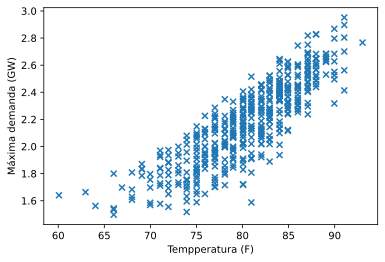

In [ ]:
df_summer = df[list(map(lambda x : str(x)[4:6] in ["06", "07", "08"], df.index))].copy()
plt.scatter(df_summer["Temp"], df_summer["Load"], marker='x')
plt.xlabel("Tempperatura (F)")
plt.ylabel("Máxima demanda (GW)")

## Modelamiento no lineal

Como se vió en la clase de clasificación lineal:

* La relación entre la alta temperatura y la demanda eléctrica está bien modelada por una función lineal durante los meses de verano(al menos en Pittsburgh)

* La electricidad en verano está dominada por las condiciones del aire (así que con temperaturas más altas viene un mayor consumo).  

* **No es el caso de todo el año**.  De hecho, si se cree en nuestro anterior modelo lineal, entonces con temperaturas más bajas seguiríamos teniendo un consumo cada vez menor (hasta que, en algún momento, comencemos a generar electricidad).  

**Si consideramos todo el año temperatura y consumo eléctrico, nuestro gráfico quedaría**


Text(0, 0.5, 'Peak Demand (GW)')

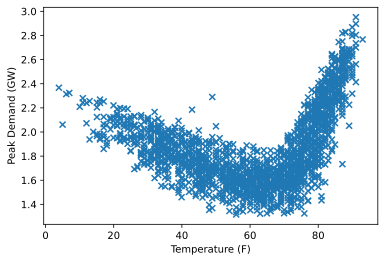

In [ ]:
plt.scatter(df["Temp"], df["Load"], marker="x")
plt.xlabel("Temperature (F)")
plt.ylabel("Peak Demand (GW)")


## Modelamiento no lineal

El gráfico captura el efecto sobre la temperatura en el gasto de energía eléctrica.
 
 * **La demanda aumenta drásticamente cuando la temperatura es sobre 70 grados Farenheit**, meses de verano, y puede ser modelado linealmente. Hay una relación con el uso del aire acondicionado.
 * **Bajos los 70 grados Farenheit**, se observa que la demanda aumenta en la medida que disminuye la temperatura. Esto se debe a que en Pittburgh en invierno se usa gas en lugar de electricidad para la calefacción.
 
 Si ajustamos el modelo de predicción lineal a los datos de demanda de todo el año nos quedaría...

(0.0, 95.0)

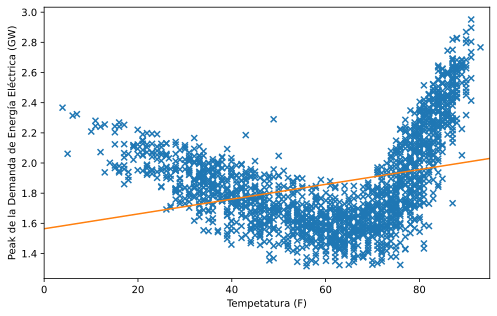

In [ ]:
X = np.array([df["Temp"].values, np.ones(len(df))]).T
y = df["Load"].values
theta = np.linalg.solve(X.T @ X, X.T @ y)

plt.figure(figsize=(8,5))
plt.scatter(df["Temp"], df["Load"], marker="x")
plt.xlabel("Tempetatura (F)")
plt.ylabel("Peak de la Demanda de Energía Eléctrica (GW)")
plt.plot([0,100], [theta[1], 100*theta[0]+theta[1]], 'C1')
plt.xlim([0,95])

## Modelamiento no lineal

En un **sentido muy preciso** esta _es_ la mejor recta que **se ajusta a los datos**: 

* Es la recta que minimiza la suma de errores cuadrados entre los puntos de datos y los puntos de esta línea (recuerde, esta es la definición de regresión lineal).  

* **Pero para este problema el ajuste es muy pobre**, la recta o nuestra hipótesis no es capaz de definir correctamente los datos y su relación. Por ejemplo, demanda máxima tiene esta característica de primero disminuir suavemente con la temperatura más alta hasta unos 70 grados, y luego aumentar rápidamente.

# Modelos no lineales

* Para capturar datos de este tipo, claramente debemos de alguna forma de **expresar las relaciones no lineales en los datos**.
* Afortunadamente, esto es posible sin dejar el dominio de la llamada "regresión lineal". 
  * No utilizar las características originales $x^{(i)}$.
  * Se construyen características que incluyan funciones no lineales.
* Por ejemplo, se podrián utilizar las siguientes características:

\begin{equation}
x^{(i)} = \left [ \begin{array}{c} (\mathrm{TemperaturaMaxima}^{(i)})^2 \\
\mathrm{TemperaturaMaxima}^{(i)} \\ 1 \end{array} \right ]
\end{equation}

# Modelos no lineales

* Que también incluye una **función cuadrática** de la variable de temperatura máxima. Si elegimos esta representación, entonces nuestra función de hipótesis lineal quedaría $h_\theta(x) = \theta^Tx$ y está dada por la ecuación:

\begin{equation}
h_\theta(x) = \theta_1 (\mathrm{TemperaturaMaxima}^{(i)})^2 + \theta_2 \mathrm{TemperaturaMaxima}^{(i)} + \theta_3
\end{equation}

La cuál, es una función _cuadrática_ para temperatura máxima.  Sin embargo, es importante señalar que la **función de hipótesis** sigue siendo **una función lineal** para los parámetros, por lo que funcionan los mismos métodos de solución que antes (incluida la solución exacta). Lo único que cambia, que tenemos una una matriz de características diferente.



## Ejemplo: Resolver un modelo no lineal

**Veamos cómo funciona esto en la práctica**  

En esta configuración vamos a normalizar las características en el rango $[-1,+1]$ incluso con la solución de mínimos cuadrados exactos (solución analítica) por razones numéricas.  Los polinomios grados altos se hacen muy grandes muy rápidamente, y si no tenemos cuidado es fácil sobrecargar el rango de valores de punto flotante al de doble precisión.

In [ ]:
x = df["Temp"].values
min_x, max_x = x.min(), x.max()
x = 2*(x - min_x)/(max_x - min_x) - 1

def ls_poly(x, y, degree):
    X = np.array([x**i for i in range(degree,-1,-1)]).T
    return np.linalg.solve(X.T @ X, X.T @ y) 

theta = ls_poly(x, y, 2)
print(theta)

[ 1.19886894 -0.19235301  1.5888731 ]


## Solución modelo no lineal (I)

Ahora que hemos calculado la solución, la vamos a graficar como en los ejercicios anteriores.  

Nuestra hipótesis ya *no es una recta*. No podemos graficarla simplemente especificando dos puntos, sin embargo, el procedimiento aproximado funciona igual que antes.

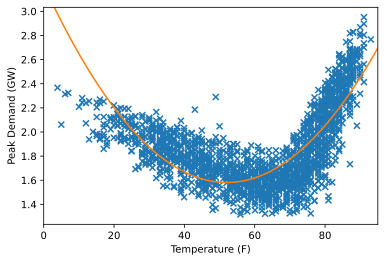

In [ ]:
def plot_regression_poly(theta):
    degree = len(theta)-1
    xt0 = np.linspace(0,95, 400)
    # Normalizamos entre [-1, 1]
    xt = 2*(xt0 - min_x)/(max_x - min_x) - 1
    Xt = np.array([xt**i for i in range(degree,-1,-1)]).T
    yt = Xt @ theta
        
    plt.scatter(df["Temp"], df["Load"], marker="x")
    ylim = plt.ylim()
    plt.plot(xt0, yt, 'C1')
    plt.xlabel("Temperature (F)")
    plt.ylabel("Peak Demand (GW)")
    plt.xlim([0,95])
    plt.ylim(ylim)
    
plot_regression_poly(theta)

## Solución modelo no lineal (II)

El gráfico anterior se ve mejor: 

* Pero la **función cuadrática** es **simétrica** alrededor de su **punto mínimo**.
* Los **datos** que estamos tratando de **ajustar** definitivamente no son simétricos. Por lo tanto, podemos querer una **función cúbica**.

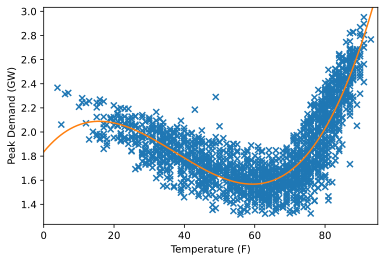

In [ ]:
plot_regression_poly(ls_poly(x,y,3))

## Solución modelo no lineal (III)

Esto se ve mejor excepto por el extremo inferior, así que tal vez un grado más (4).

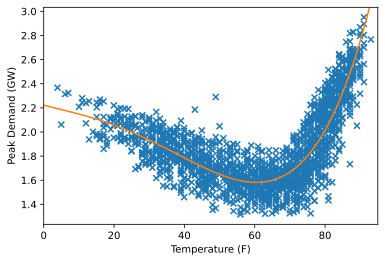

In [ ]:
plot_regression_poly(ls_poly(x,y,4))

## Solución modelo no lineal (IV)

Esto está empezando a parecer un buen ajuste a los datos.  Pero hasta ahora, utilizar un grado alto ha sido  la mejor opción. 

¿Y que sucederá si probamos con un polinomio de grado 10?

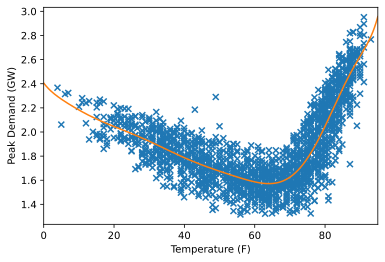

In [ ]:
plot_regression_poly(ls_poly(x,y,10))

## Solución modelo no lineal (V)

Al parecer un polinomio de grado 10 funciona bien.

Ahora aumentemos a un polinomio más complejo, de grado 100.

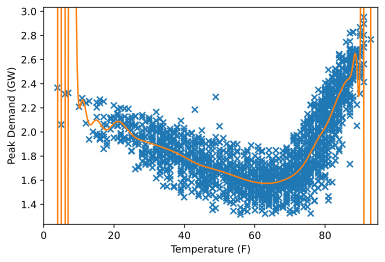

In [ ]:
plot_regression_poly(ls_poly(x,y,100))

## Solución modelo no lineal (VI)

Aunque el resultado se ve aceptable no es bueno:

* Sobre todo en los puntos extremos de los datos.
  * Donde los puntos de los datos estan menos espaciados, se obtienen patrones raros.
  * El ajuste a nivel de mínimos cuadrados es bueno debido a que cada punto de la base de datos se puede predecir del modelo, pero si trata de predecir un valor extremo que no está en la base de datos, el error es grande.
* Este modelo es una mala aproximación para datos subyacentes o que no se encuentran en la base de datos.
* Este tipo de problemas nos lleva a discutir dos conceptos importantes en el aprendizaje automático: **Generalización** y **sobreajuste** (*overfitting*).

# Generalization and overfitting

El problema canónico del aprendizaje automático **no es minmizar la función objetivo** dado un conjunto de datos: 

\begin{equation}
\DeclareMathOperator*{\minimize}{minimize}
\minimize_\theta \; \frac{1}{m}\sum_{i=1}^m \ell \left(h_\theta(x^{(i)},y^{(i)} \right)
\end{equation}

Lo que se esperara es que la función **generalice** sobre los nuevos ejemplos que nosotros no usamos para entrenar el modelo (aunque se utilizará la misma distribución de los ejemplos utilizados para el entrenamiento.

Como se vió en los ejemplos anteriores, los polinomios de mayor grado mostraron un sobreajuste (*overfitting*) sobre el conjunto de entrenamiento, error de pérdida bajo. Pero la **idea fundamental** es crear modelos que generalicen bien, donde también se tenga un valor de pérdida bajo para un conjunto nuevo de ejemplos.

**Sobreajuste en mínimos cuadrados** Como ejemplo simple, consideremos el caso de la regresión por mínimos cuadrados, cuando elegimos que el número de características $n$ sea el mismo que el número de ejemplos $m$ (por ejemplo, podríamos lograrlo eligiendo un polinomio de muy alto grado); asumamos también que los datos subyacentes son la distinción para cada punto de datos, lo que implicará (no nos preocuparemos de probar esto formalmente, puede tomarse como un hecho) que esa característica para cada ejemplo es linealmente independiente.  Entonces podemos mirar nuestra solución de mínimos cuadrados

\begin{equation}
\begin{split}
\theta & = (X^T X)^{-1} X^T y   \\
& = X^{-1} X^{-T} X^T y \\
& = X^{-1} y
\end{split}
\end{equation}

(Asumimos que $X$ is invertible, y que la propiedad $(AB)^{-1} = B^{-1} A^{-1}$ cuando $A$ y $B$ son invertibles) y por lo tanto tenemos $X\theta = y$, es decir, las predicciones sobre el conjunto de entrenamiento son perfectas.  Sin embargo, a menos que el modelo fuera capturado exactamente por puntos de $m$, no habría razón para esperar que el ajuste resultante se generalizara bien a nuevos puntos. 

## Sobreajuste (*overfitting*) y complejidad del modelo

*  A medida que el modelo se hace **más complejo**, la pérdida de entrenamiento siempre disminuye.
*  Pero para la **generalización** la pérdida disminuye hasta un punto, y luego comienza a aumentar


<center>
    <img src='images/overfitting.svg'style="width: 400px;">
</center>

Nuestro **objetivo** al elegir el modelo "correcto" para un problema particular de aprendizaje automático es encontrar el modelo con el **menor error de generalización**, el mínimo en la línea roja de arriba.  

Sin embargo, **no podemos hacerlo** utilizando sólo **el conjunto de entrenamiento**, porque el rendimiento en el conjunto de entrenamiento (la línea azul), **no nos da ninguna pista** sobre el **rendimiento de la pérdida de generalización**.


### Cross validation

Aunque es difícil cuantificar el verdadero error de generalización (es decir, el error de estos
algoritmos sobre la distribución completa de los posibles ejemplos), podemos
aproximarlo por medio de la validación cruzada (*cross validation*).

La idea básica es dividir el conjunto de datos en un conjunto de entrenamiento y un conjunto de reserva (*holdout*). 


<center>
    <img src='images/cv_split.svg'style="width: 700px;">
</center>

El **entrenamiento del modelo** se hace con el conjunto de datos definido para el entrenamiento (70%) y la **evaluación del modelo**, revisar si el modelo generalizó o no, se hace con el resto de los datos (datos reservados para este fin, 30%).

In [ ]:
np.random.seed(10)
perm = np.random.permutation(X.shape[0])
idx_train = perm[:int(len(perm)*0.7)]
idx_cv = perm[int(len(perm)*0.3):]

x_train, y_train = df["Temp"].iloc[idx_train].values, df["Load"].iloc[idx_train].values
x_cv, y_cv = df["Temp"].iloc[idx_cv].values, df["Load"].iloc[idx_cv].values

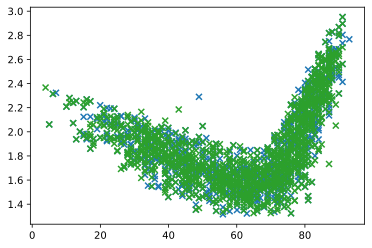

In [ ]:
plt.scatter(x_train, y_train, marker='x', color="C0")
plt.scatter(x_cv, y_cv, marker='x', color="C2")

### Parámetros e hiperparámetros

Hasta el momento no hemos referido a las **variables $\theta$** como **parámetros** de un algoritmo de aprendizaje automático.

Pero existen otros valores que afectan el rendimiento del clasificador: grados del polinomio, cantidad de regularización, etc. Estos valores no son parte del modelo pero si afectan los valores del los parámetros, y son llamados **hiperparámetros** del algoritmo.

La idea básica de la **validación cruzada** es:
* Encontrar los mejores **parámetros** para el conjunto de entrenamiento.
* Usar el conjunto de validación para encontrar los mejores **hiperparámetros**

### Entrenamiento y pérdida de la validación cruzada por grado

In [ ]:
min_x_train, max_x_train = x_train.min(), x_train.max()
x_train = 2*(x_train - min_x_train)/(max_x_train - min_x_train) - 1
x_cv = 2*(x_cv - min_x_train)/(max_x_train - min_x_train) - 1

def poly_feat(x, degree):
    return np.array([x**i for i in range(degree,-1,-1)]).T
    
err_train = []
err_cv = []
for i in range(50):
    theta = ls_poly(x_train, y_train, i)
    err_train.append(((poly_feat(x_train,i) @ theta - y_train)**2).mean())
    err_cv.append(((poly_feat(x_cv,i) @ theta - y_cv)**2).mean())

Text(0, 0.5, 'Mean squared error')

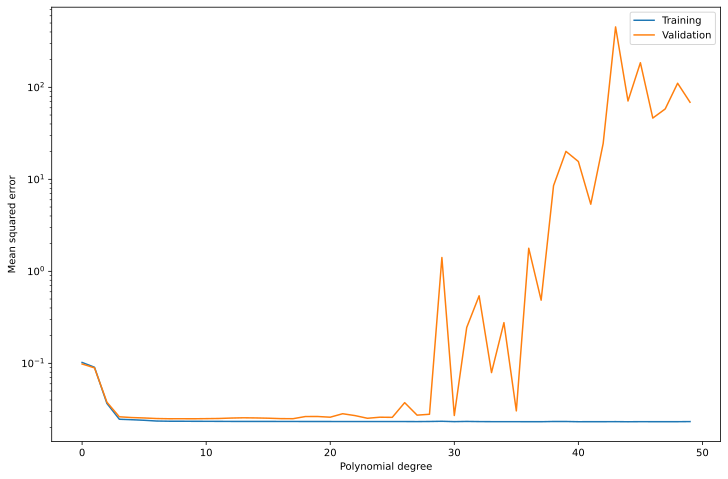

In [ ]:
plt.figure(figsize=(12,8))
plt.semilogy(range(50), err_train, range(50), err_cv)
plt.legend(["Training", "Validation"])
plt.xlabel("Polynomial degree")
plt.ylabel("Mean squared error")

Text(0, 0.5, 'Mean squared error')

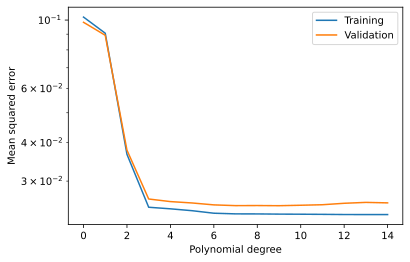

In [ ]:
plt.semilogy(range(15), err_train[:15], range(15), err_cv[:15])
plt.legend(["Training", "Validation"])
plt.xlabel("Polynomial degree")
plt.ylabel("Mean squared error")

### K-fold cross validation

Una versión más complicada de la validación cruzada, pero significativamente más utilizada en la práctica.

Se divide el conjunto de datos en $k$ subconjuntos disociados (rodajas, *folds*):
1. Se entrena en $k - 1$ rodajas.
2. Se evalúa en la rodaja (*fold*) restante
3. Repetir $k$ veces, guardando una rodaja o *fold* para validación en cada ciclo.

<center>
    <img src='images/kfold.svg'style="width: 700px;">
</center>

Por cada ciclo de guarda el error promedio de cada uno de los *folds*. Luego, se calculan las métricas por cada *fold* y globalmente.


### Variantes de la validación cruzada

Hay algunas variantes adicionales de validación cruzada que son lo suficientemente comunes como que deben ser consideradas.

* **Validación cruzada *Leave-one-out***: Es el límite de la validación cruzada de *k-fold*. Cada *fold* es **sólo un ejemplo** (entrenamos todos los ejemplos y probamos solo con un ejemplo para todos los $k$). $k$ = Tamaño de la muestra.

* **Validación cruzada estratificada (*stratified cross-validation*)**: Mantener un porcentaje aproximadamente igual de ejemplos positivos/negativos (o cualquier otra característica), en cada *fold*.

**NOTA**: La validación cruzada de $k-fold$ no siempre es mejor (por ejemplo, en la predicción de series de tiempo, querría que el conjunto de validación se produjera después del conjunto de entrenamiento)

## Regularización

Hemos visto que el **grado de un polinomio** actúa como una medida natural de la "complejidad" del modelo, los polinomios de **mayor grado** son **más complejos** (llevados a el límite, nos ajustamos exactamente a cualquier conjunto de datos finitos)

Pero la adaptación de estos modelos también requiere **coeficientes extremadamente grandes** en estos
polinomios.

Para el polinomio de grado 50, los primeros coeficientes son: $\theta=-3.88\times10^6$, $\theta=7.60\times10^6$, $\theta=3.94\times10^6$, $\theta=-2.60\times10^6$, $...$

Eston nos sugiere una alternativa para mantener el control de la complejidad del modelo:
* Mantener los pesos de los parámetros pequeños (**regularización**)

### Minimización de pérdidas regularizada

Esto nos lleva de nuevo al problema de la minimización de pérdidas regularizada que vimos antes,
pero con un poco más de contexto ahora:

\begin{equation}
\minimize_\theta \; \frac{1}{m}\sum_{i=1}^m \ell \left(h_\theta(x^{(i)},y^{(i)} \right) + \lambda \sum_{i=1}^n ||\theta_i||^2_2
\end{equation}

Esta formulación intercambia la pérdida en el conjunto de entrenamiento con una penalización en los valores altos de los parámetros.

Variando $\lambda$ de cero (**sin regularización**) a infinito (regularización infinita, es decir
todos los parámetros serán cero), podemos barrer diferentes conjuntos de complejidad del modelo.



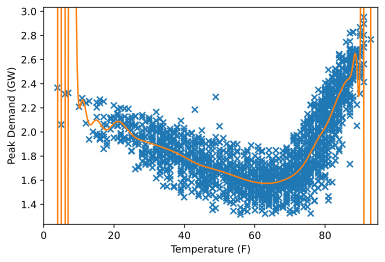

In [ ]:
plot_regression_poly(ls_poly(x,y,100))

También veamos los pesos reales involucrados en este ajuste.

In [ ]:
theta = ls_poly(x,y,100)
print(theta[:4])

[ 892897.60911472 -347761.37873535 -207927.35520776    5917.82757345]


### Regularización en mínimos cuadrados (*least squares*) (I)

Para los mínimos cuadrados, hay una solución simple al problema de la minimización de las pérdidas regularizadas

Para ver esto, consideremos el objetivo con la regularización $\ell_2$ y la pérdida al cuadrado.

\begin{equation}
\minimize_\theta \; \frac{1}{m}\sum_{i=1}^m \left (\theta^T x^{(i)} - y^{(i)} \right) + \lambda \sum_{j=1}^n \theta_j^2
\end{equation}

Tomar los gradientes con las mismas reglas que antes da:


\begin{equation}
\nabla_\theta \left (\sum_{i=1}^m (\theta^T x^{(i)} - y^{(i)})^2 + \lambda ||\theta||^2_2 \right) = 2X^T(X\theta -y) + 2\lambda\theta
\end{equation}

### Regularización en mínimos cuadrados (*least squares*) (II)

Establecer un gradiente igual a cero conduce a la solución:

\begin{equation}
2 X^T X \theta + 2 \lambda \theta = 2 X^T y => \theta = (X^T X + \lambda I)^{-1} X^T y
\end{equation}

Se ve igual a las ecuaciones vistas en clases, pero con un término adicional $\lambda I$.

### Visualizando la regularización


Veamos cómo se ve esto en nuestro **polinomio de 100 grados**. Si $\lambda = 0$, obtenemos.

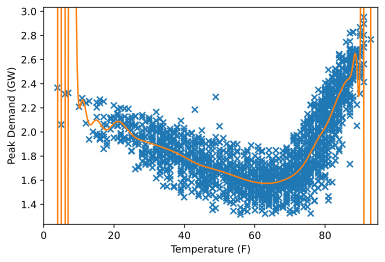

In [ ]:
plot_regression_poly(ls_poly(x,y,100))

Si en cambio elegimos $\lambda = 1$, obtenemos la siguiente cifra.

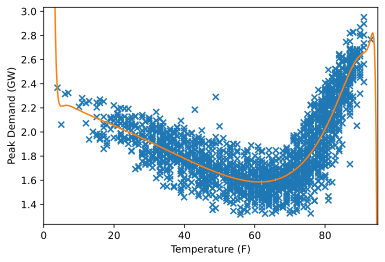

In [ ]:
def ls_poly_reg(x, y, lam, degree):
    X = np.array([x**i for i in range(degree,-1,-1)]).T
    return np.linalg.solve(X.T @ X + lam*np.eye(X.shape[1]), X.T @ y)

theta = ls_poly_reg(x, y, 1.0, 100)
plot_regression_poly(theta)

Lo que sucede fuera del rango de los datos todavía está mal especificado, pero esto se ve sustancialmente mejor que lo que teníamos antes.  Y podemos ver que la magnitud de los parámetros $\theta$ son mucho más pequeños.

In [ ]:
print(theta[:5])

[ 0.00567776 -0.02367691  0.00552413 -0.02264579  0.00538301]


¿Qué pasa si regularizamos más?  A medida que aumentamos el **hiperparámetro** $\lambda$, la función subyacente (de nuevo, centrándonos principalmente aquí en los datos entre los puntos extremos) parece generalmente más suave.

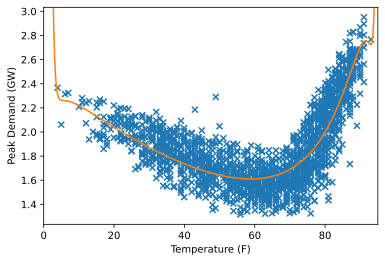

In [ ]:
theta = ls_poly_reg(x, y, 10.0, 100)
plot_regression_poly(theta)

Y más... $\lambda = 100$

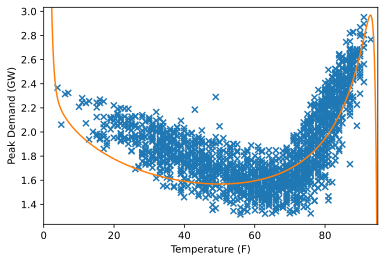

In [ ]:
theta = ls_poly_reg(x, y, 100.0, 100)
plot_regression_poly(theta)

### Entrenamiento/Pérdida de validación cruzada con regularización

Text(0, 0.5, 'Coefficient weight')

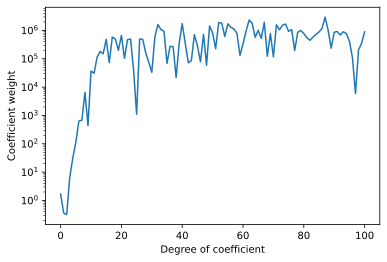

In [ ]:
theta = ls_poly(x, y, 100)
plt.semilogy(range(101), np.abs(theta[::-1]))
plt.xlabel("Degree of coefficient")
plt.ylabel("Coefficient weight")

Revisemos los la relación entre el grado del polinomio y valor de los parámetros.

Text(0, 0.5, 'Coefficient weight')

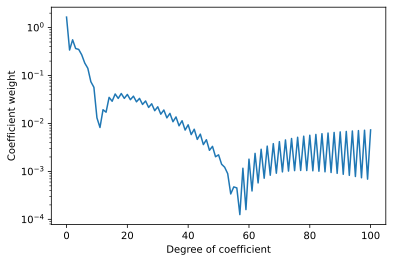

In [ ]:
theta = ls_poly_reg(x, y, 10.0, 100)
plt.semilogy(range(101), np.abs(theta[::-1]))
plt.xlabel("Degree of coefficient")
plt.ylabel("Coefficient weight")

###  Rendimientos de la regularización y la validación cruzada

También podemos ilustrar los efectos de la regularización en lo que se refiere al rendimiento del entrenamiento y la validación.  Al igual que hicimos con el grado del polinomio, podemos considerar los errores de entrenamiento y validación para diferentes cantidades de regularización.

### Gráfico valor $\lambda$ versus promedio de la pérdida al cuadrado

Seleccionamos el rango de $\lambda$ que tiene menor valor promedio de pérdida al cuadrado.

Text(0, 0.5, 'Average squared loss')

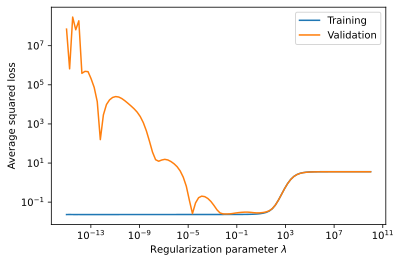

In [ ]:
lam = np.logspace(-15,10,100)

def poly_feat(x, degree):
    return np.array([x**i for i in range(degree,-1,-1)]).T

phi_train = poly_feat(x_train, 100)
phi_cv = poly_feat(x_cv,100)
err_train = [((phi_train @ ls_poly_reg(x_train, y_train, l, 100) - y_train)**2).mean() for l in lam]
err_cv = [((phi_cv @ ls_poly_reg(x_train, y_train, l, 100) - y_cv)**2).mean() for l in lam]

plt.loglog(lam, err_train, lam, err_cv)
plt.legend(["Training", "Validation"])
plt.xlabel("Regularization parameter $\lambda$")
plt.ylabel("Average squared loss")

### Gráfico valor $\lambda$ versus promedio de la pérdida al cuadrado

Text(0, 0.5, 'Average squared loss')

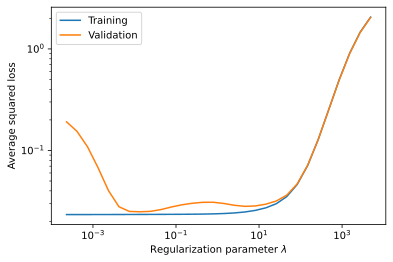

In [ ]:
plt.loglog(lam[45:75], err_train[45:75], lam[45:75], err_cv[45:75])
plt.legend(["Training", "Validation"])
plt.xlabel("Regularization parameter $\lambda$")
plt.ylabel("Average squared loss")

### Selección del parámetro de regularización - $\lambda$

Esta gráfica sugiere que los parámetros de regularización entre $10^{-2}$ y $10^1$ parecen funcionar mejor para este problema (yo personalmente no le daría mucha importancia al salto medio entre los dos extremos, ya que esto es probablemente un artificio del conjunto de validación cruzada en particular, y todo el rango todavía sufre un error relativamente bajo.

## Notación para características más generales (I)

Anteriormente, no incluimos ninguna de las características polinómicas directamente en $x$; en cambio, $x$ sólo captura las verdaderas entradas subyacentes al algoritmo, los elementos que estamos proporcionando que no se derivan de las otras cantidades (y nótese que tampoco incluye la característica constante, por ejemplo).  En su lugar, definiremos un **mapeo de características** (_feature mapping_).

\begin{equation}
\phi : \mathbb{R}^n \rightarrow \mathbb{R}^k
\end{equation}

Será una función que mapea $n$-entradas dimensionales a $k$ **funciones dimensionales**.  Todo lo demás permanece igual, excepto que ahora consideramos la función de hipótesis que es lineal en estos vectores de características, es decir,

\begin{equation}
h_{\theta}(x) = \theta^T \phi(x)
\end{equation}

parametrizado por $\theta \in \mathbb{R}^k$.

## Notación para características más generales (II)

Por ejemplo, para un polinomio de grado 3 (de una variable de entrada), podemos definir $\phi : \mathbb{R} \rightarrow \mathbb{R}^4$ como:

\begin{equation}
\phi(x) = \left [ \begin{array}{c} x^3 \\ x^2 \\ x \\ 1 \end{array} \right ]
\end{equation}

y de manera similar para un grado mayor de polinomios.  Esperemos que esté claro que esto es sólo una definición notacional, pero es útil para empezar un poco más preciso sobre estas características no lineales.







## Notación para características más generales (III)

Una mejor generalización de los polinomios incluye todos los términos del polinomio entre la entrada bruta (_raw inputs_) hasta el grado $d$.

\begin{equation}
x \in \mathbb{R}^k \Rightarrow \phi(x) = \left \{ \prod^k_{i=1} x_i^{b_i} : \sum^n_{i=1} b_i \leq d \right \} \in \mathbb{R}^{\left( \frac{k+d}{k} \right)}
\end{equation}









## Función de base radial (_Radial basis functions_ - RBF) (I)

Para $x \in \mathbb{R}^k$, seleccionamos un conjunto de $k$ centros, $\mu^{(1)}, ...,\mu^{(k)}$.

\begin{equation}
\phi : \mathbb{R} \rightarrow \mathbb{R}^k = \left [ \begin{array}{c} 
\exp \left(\frac{-(x - \mu^{(1)})^2}{2\sigma^2} \right) \\
\exp \left(\frac{-(x - \mu^{(2)})^2}{2\sigma^2} \right) \\
\vdots \\
\exp \left(\frac{-(x - \mu^{(k-1)})^2}{2\sigma^2} \right) \\
1
\end{array} \right ]
\end{equation}

donde $mu^{(1)}, \ldots, mu^{(k-1)} \in \mathbb{R}$ (llamada las medias) y $\sigma \in \mathbb{R}$ (llamado el ancho de banda) son los hiperparámetros de este vector de características.

## Función de base radial (_Radial basis functions_ - RBF) (II)


Veamos uno solo de estos términos $\phi_j(x)$ (este es el elemento $j$-ésimo del vector de características, porque recuerden que $\phi(x)$ produce un vector $k$-dimensional.

\begin{equation}
\phi_j(x) = \exp \left(\frac{-(x - \mu^{(j)})^2}{2\sigma^2} \right)
\end{equation}

## Función de base radial (_Radial basis functions_ - RBF)

Si se está familiarizado con la distribución gaussiana, se puede reconocer que ésta tiene un aspecto 
similar a la función de densidad gaussiana (aunque sin la constante normalizadora).  
Una sola dimensión de esta característica (para entradas variables $x$, y aquí suponiendo que la media 
$\mu^{(j)} = 1,5$ y $\sigma = 0,4$) tiene el siguiente aspecto:

Text(0, 0.5, '$\\phi_j(x)$')

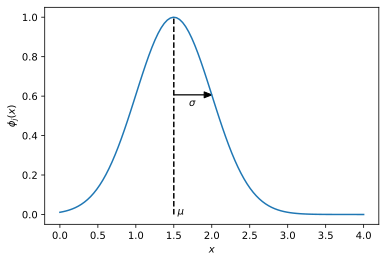

In [ ]:
x = np.linspace(0,4,100)
mu_j = 1.5
sigma = 0.5
plt.plot(x,np.exp(-(x-mu_j)**2 / (2*sigma**2)))
plt.plot([1.5,1.5], [0,1], 'k--')
plt.text(1.55, 0, r"$\mu$")
plt.arrow(1.5, np.exp(-0.5), 0.5-0.1, 0, head_width=0.03, head_length=0.1, fc='k')
plt.text(1.7, 0.55, r"$\sigma$")
plt.xlabel("$x$")
plt.ylabel(r"$\phi_j(x)$")

### Dificultades con las características generales

El reto con estas características generales no lineales es que el número de
las características potenciales crecen muy rápidamente en la dimensionalidad de la entrada bruta.

* Polinomios: $k$-dimension de entrada bruta $\Rightarrow \binom{k+d}{k} = O(d^k)$ total de características (para un $d$ fijo.

* RBFs: $k$-dimension de entrada bruta, una grilla uniforme con $d$ centros por cada una dimensión $\Rightarrow d^k$ de características totales.

## Clasificación no lineal

In [ ]:
import numpy as np
import sklearn.datasets
dat = sklearn.datasets.load_breast_cancer()

ix = np.where(dat["feature_names"] == "mean area")[0][0]
iy = np.where(dat["feature_names"] == "mean concave points")[0][0]

X = np.asarray([dat["data"][:,ix], dat["data"][:,iy]]).T
y = (1.*(dat["target"]==np.where(dat["target_names"] == "malignant")[0][0]) +
     -1.*(dat["target"]==np.where(dat["target_names"] == "benign")[0][0]))

In [ ]:
def plot_classification_sklearn(model, norm, feat):
    x_range = [0,2600]
    y_range = [0, 0.21]

    # plot classifcation regions
    grid=200
    xx,yy = np.meshgrid(np.linspace(x_range[0], x_range[1], grid),
                        np.linspace(y_range[0], y_range[1], grid))
    X_ = np.array([np.ravel(xx), np.ravel(yy)]).T
    zz = model.decision_function(feat(norm.transform(X_))).reshape(grid,grid)
    cs = plt.contourf(xx,yy,zz, zz,levels=[-float("inf"),0,float("inf")],alpha=0.2,colors=["b","r"])
    plt.contour(cs, colors='k')

    s1 = plt.scatter(dat["data"][:,ix][dat["target"]==1], dat["data"][:,iy][dat["target"]==1], marker='x', color='C0')
    s2 = plt.scatter(dat["data"][:,ix][dat["target"]==0], dat["data"][:,iy][dat["target"]==0], marker='+', color='C3')
    plt.xlim([0,2600])
    plt.ylim([0,0.21])
    plt.xlabel("Mean Area")
    plt.ylabel("Mean Concave Points")
    plt.legend([s1,s2], ['Benign', 'Malignant'])

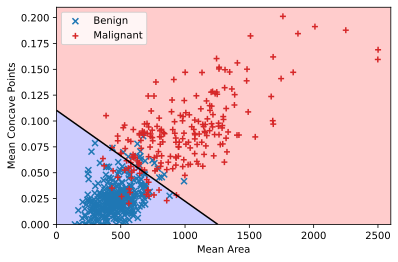

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

norm = MinMaxScaler(feature_range=(-1,1))
model = SVC(kernel='linear', C = 100.0)
model.fit(norm.fit_transform(X), y)
plot_classification_sklearn(model, norm, lambda x : x)

### Ajustamos el polinomio a uno de grado $d$=2

In [ ]:
from itertools import combinations_with_replacement

def poly_feat(X,d):
    X_ = np.hstack([X, np.ones((X.shape[0],1))]).T # add ones
    return np.array([np.array(a).prod(axis=0) for a in combinations_with_replacement(X_,d)]).T

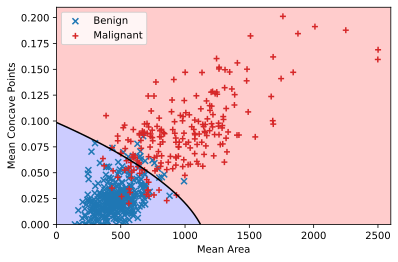

In [ ]:
model = SVC(kernel='linear', C=100.)

Phi = poly_feat(norm.fit_transform(X), 2)
model.fit(Phi, y)
plot_classification_sklearn(model, norm, lambda X : poly_feat(X, 2))

### Ajustamos el polinomio a uno de grado $d$=3

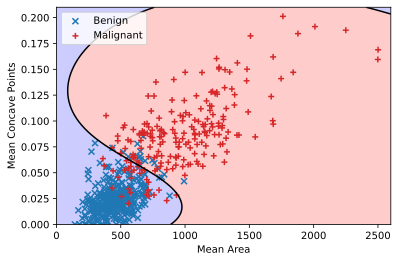

In [ ]:
model = SVC(kernel='linear', C=100.)

Phi = poly_feat(norm.fit_transform(X), 3)
model.fit(Phi, y)
plot_classification_sklearn(model, norm, lambda X : poly_feat(X, 3))

### Ajustamos el polinomio a uno de grado $d$=10

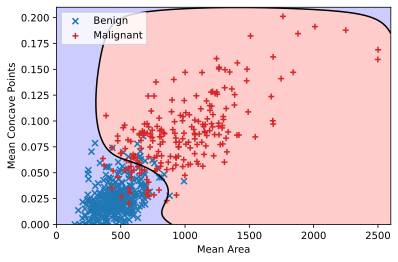

In [ ]:
model = SVC(kernel='linear', C=100.)

Phi = poly_feat(norm.fit_transform(X), 10)
model.fit(Phi, y)
plot_classification_sklearn(model, norm, lambda X : poly_feat(X, 10))

### Finalmente, usamos el truco de la media

In [ ]:
def rbf_feat(X, mu, sig):
    return np.exp(-sqdist(X,mu) / (2*sig**2))

XY = np.meshgrid(np.linspace(-1,1,10), np.linspace(-1,1,10))
mu = np.array([XY[0].ravel(), XY[1].ravel()]).T
sig = np.sqrt(np.median(sqdist(mu,mu)))

model = SVC(kernel='linear', C=0.1)
Phi = rbf_feat(norm.fit_transform(X), mu, sig)
model.fit(Phi, y)
plot_classification_sklearn(model, norm, lambda X : rbf_feat(X, mu, sig))